# Training for Semantic Segmentation

Author: Farnaz Nouraei

Spring 2021, Brown University

## PREREQUISITES

In [64]:
import os
import yaml
import time
import shutil
import torch
import random
import argparse
import numpy as np

from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loss import get_loss_function
from ptsemseg.loader import get_loader
from ptsemseg.utils import get_logger
from ptsemseg.metrics import runningScore, averageMeter
from ptsemseg.augmentations import get_composed_augmentations
from ptsemseg.schedulers import get_scheduler
from ptsemseg.optimizers import get_optimizer

from tensorboardX import SummaryWriter


torch.backends.cudnn.enabled = True
print('Torch - Cuda Version: {}, is_cuda_available: {}'.format(torch.__version__, torch.cuda.is_available()))
if torch.cuda.is_available(): 
    print('Current Cuda Device:',torch.cuda.current_device())
    print('Device Name:',torch.cuda.get_device_name())
    CUDA_LAUNCH_BLOCKING=1


# Data/model Properties

MODEL = "segnet"
DATASET = "pascal"

INPUT_SIZE = 128 # Input image width/height
OUTPUT_SIZE = 128 # Output image width/height (as defined by model)
OUTPUT_CLASSES = 21 # Number of output classes in dataset (pascal)
IN_CHANNELS = 3      # RGB Input

# Training Hyperparams


BATCH_SIZE = 4 # Batch - VRAM limited

LEARNING_RATE = 0.0001 # Model learning rate
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.99

NUM_EPOCHS = 2000 # Number of train steps per model train
DO_VAL = True
VAL_FREQ = 10 # How often we do validation
LOSS_SIGMOID_NORM = False # use a sigmoid normalization before DICE loss calculation
PRETRAINED = True # pretrain the model with VGG16 ImageNet parameters
LOSS_TYPE = "WBCE" # "BCE" , "WBCE" , "Dice"
# Saving

#MODEL_NAME = 'model_'+ MODEL # Model name to LOAD FROM (LOOKS IN SAVE_PATH DIRECTORY)
SAVE_FREQ = 100 # How often we save the model (epochs)


Torch - Cuda Version: 1.7.1, is_cuda_available: True
Current Cuda Device: 0
Device Name: GeForce GTX 1080 Ti


## MODELS

### SegNet

Implementation from https://github.com/meetshah1995/pytorch-semseg

In [65]:
# model utilities


import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.models as models


from torch.autograd import Variable

class conv2DBatchNorm(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cb_unit = nn.Sequential(conv_mod, nn.BatchNorm2d(int(n_filters)))
        else:
            self.cb_unit = nn.Sequential(conv_mod)

    def forward(self, inputs):
        outputs = self.cb_unit(inputs)
        return outputs


class conv2DGroupNorm(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cg_unit = nn.Sequential(conv_mod, nn.GroupNorm(n_groups, int(n_filters)))

    def forward(self, inputs):
        outputs = self.cg_unit(inputs)
        return outputs


class deconv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNorm, self).__init__()

        self.dcb_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
        )

    def forward(self, inputs):
        outputs = self.dcb_unit(inputs)
        return outputs


class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class conv2DGroupNormRelu(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cgr_unit = nn.Sequential(
            conv_mod, nn.GroupNorm(n_groups, int(n_filters)), nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        outputs = self.cgr_unit(inputs)
        return outputs


class deconv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNormRelu, self).__init__()

        self.dcbr_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True),
        )

    def forward(self, inputs):
        outputs = self.dcbr_unit(inputs)
        return outputs


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 0), nn.ReLU())
            self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 0), nn.ReLU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], 1))


class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module): 
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs


class residualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, n_filters, stride=1, downsample=None):
        super(residualBlock, self).__init__()

        self.convbnrelu1 = conv2DBatchNormRelu(in_channels, n_filters, 3, stride, 1, bias=False)
        self.convbn2 = conv2DBatchNorm(n_filters, n_filters, 3, 1, 1, bias=False)
        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.convbnrelu1(x)
        out = self.convbn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out


class residualBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, n_filters, stride=1, downsample=None):
        super(residualBottleneck, self).__init__()
        self.convbn1 = nn.Conv2DBatchNorm(in_channels, n_filters, k_size=1, bias=False)
        self.convbn2 = nn.Conv2DBatchNorm(
            n_filters, n_filters, k_size=3, padding=1, stride=stride, bias=False
        )
        self.convbn3 = nn.Conv2DBatchNorm(n_filters, n_filters * 4, k_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.convbn1(x)
        out = self.convbn2(out)
        out = self.convbn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class linknetUp(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(linknetUp, self).__init__()

        # B, 2C, H, W -> B, C/2, H, W
        self.convbnrelu1 = conv2DBatchNormRelu(
            in_channels, n_filters / 2, k_size=1, stride=1, padding=1
        )

        # B, C/2, H, W -> B, C/2, H, W
        self.deconvbnrelu2 = nn.deconv2DBatchNormRelu(
            n_filters / 2, n_filters / 2, k_size=3, stride=2, padding=0
        )

        # B, C/2, H, W -> B, C, H, W
        self.convbnrelu3 = conv2DBatchNormRelu(
            n_filters / 2, n_filters, k_size=1, stride=1, padding=1
        )

    def forward(self, x):
        x = self.convbnrelu1(x)
        x = self.deconvbnrelu2(x)
        x = self.convbnrelu3(x)
        return x


class FRRU(nn.Module):
    """
    Full Resolution Residual Unit for FRRN
    """

    def __init__(self, prev_channels, out_channels, scale, group_norm=False, n_groups=None):
        super(FRRU, self).__init__()
        self.scale = scale
        self.prev_channels = prev_channels
        self.out_channels = out_channels
        self.group_norm = group_norm
        self.n_groups = n_groups

        if self.group_norm:
            conv_unit = conv2DGroupNormRelu
            self.conv1 = conv_unit(
                prev_channels + 32,
                out_channels,
                k_size=3,
                stride=1,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )
            self.conv2 = conv_unit(
                out_channels,
                out_channels,
                k_size=3,
                stride=1,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )

        else:
            conv_unit = conv2DBatchNormRelu
            self.conv1 = conv_unit(
                prev_channels + 32, out_channels, k_size=3, stride=1, padding=1, bias=False
            )
            self.conv2 = conv_unit(
                out_channels, out_channels, k_size=3, stride=1, padding=1, bias=False
            )

        self.conv_res = nn.Conv2d(out_channels, 32, kernel_size=1, stride=1, padding=0)

    def forward(self, y, z):
        x = torch.cat([y, nn.MaxPool2d(self.scale, self.scale)(z)], dim=1)
        y_prime = self.conv1(x)
        y_prime = self.conv2(y_prime)

        x = self.conv_res(y_prime)
        upsample_size = torch.Size([_s * self.scale for _s in y_prime.shape[-2:]])
        x = F.upsample(x, size=upsample_size, mode="nearest")
        z_prime = z + x

        return y_prime, z_prime


class RU(nn.Module):
    """
    Residual Unit for FRRN
    """

    def __init__(self, channels, kernel_size=3, strides=1, group_norm=False, n_groups=None):
        super(RU, self).__init__()
        self.group_norm = group_norm
        self.n_groups = n_groups

        if self.group_norm:
            self.conv1 = conv2DGroupNormRelu(
                channels,
                channels,
                k_size=kernel_size,
                stride=strides,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )
            self.conv2 = conv2DGroupNorm(
                channels,
                channels,
                k_size=kernel_size,
                stride=strides,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )

        else:
            self.conv1 = conv2DBatchNormRelu(
                channels, channels, k_size=kernel_size, stride=strides, padding=1, bias=False
            )
            self.conv2 = conv2DBatchNorm(
                channels, channels, k_size=kernel_size, stride=strides, padding=1, bias=False
            )

    def forward(self, x):
        incoming = x
        x = self.conv1(x)
        x = self.conv2(x)
        return x + incoming


class residualConvUnit(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(residualConvUnit, self).__init__()

        self.residual_conv_unit = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size),
        )

    def forward(self, x):
        input = x
        x = self.residual_conv_unit(x)
        return x + input


class multiResolutionFusion(nn.Module):
    def __init__(self, channels, up_scale_high, up_scale_low, high_shape, low_shape):
        super(multiResolutionFusion, self).__init__()

        self.up_scale_high = up_scale_high
        self.up_scale_low = up_scale_low

        self.conv_high = nn.Conv2d(high_shape[1], channels, kernel_size=3)

        if low_shape is not None:
            self.conv_low = nn.Conv2d(low_shape[1], channels, kernel_size=3)

    def forward(self, x_high, x_low):
        high_upsampled = F.upsample(
            self.conv_high(x_high), scale_factor=self.up_scale_high, mode="bilinear"
        )

        if x_low is None:
            return high_upsampled

        low_upsampled = F.upsample(
            self.conv_low(x_low), scale_factor=self.up_scale_low, mode="bilinear"
        )

        return low_upsampled + high_upsampled


class chainedResidualPooling(nn.Module):
    def __init__(self, channels, input_shape):
        super(chainedResidualPooling, self).__init__()

        self.chained_residual_pooling = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.MaxPool2d(5, 1, 2),
            nn.Conv2d(input_shape[1], channels, kernel_size=3),
        )

    def forward(self, x):
        input = x
        x = self.chained_residual_pooling(x)
        return x + input


class pyramidPooling(nn.Module):
    def __init__(
        self, in_channels, pool_sizes, model_name="pspnet", fusion_mode="cat", is_batchnorm=True
    ):
        super(pyramidPooling, self).__init__()

        bias = not is_batchnorm

        self.paths = []
        for i in range(len(pool_sizes)):
            self.paths.append(
                conv2DBatchNormRelu(
                    in_channels,
                    int(in_channels / len(pool_sizes)),
                    1,
                    1,
                    0,
                    bias=bias,
                    is_batchnorm=is_batchnorm,
                )
            )

        self.path_module_list = nn.ModuleList(self.paths)
        self.pool_sizes = pool_sizes
        self.model_name = model_name
        self.fusion_mode = fusion_mode

    def forward(self, x):
        h, w = x.shape[2:]

        if self.training or self.model_name != "icnet":  # general settings or pspnet
            k_sizes = []
            strides = []
            for pool_size in self.pool_sizes:
                k_sizes.append((int(h / pool_size), int(w / pool_size)))
                strides.append((int(h / pool_size), int(w / pool_size)))
        else:  # eval mode and icnet: pre-trained for 1025 x 2049
            k_sizes = [(8, 15), (13, 25), (17, 33), (33, 65)]
            strides = [(5, 10), (10, 20), (16, 32), (33, 65)]

        if self.fusion_mode == "cat":  # pspnet: concat (including x)
            output_slices = [x]

            for i, (module, pool_size) in enumerate(zip(self.path_module_list, self.pool_sizes)):
                out = F.avg_pool2d(x, k_sizes[i], stride=strides[i], padding=0)
                # out = F.adaptive_avg_pool2d(x, output_size=(pool_size, pool_size))
                if self.model_name != "icnet":
                    out = module(out)
                out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
                output_slices.append(out)

            return torch.cat(output_slices, dim=1)
        else:  # icnet: element-wise sum (including x)
            pp_sum = x

            for i, (module, pool_size) in enumerate(zip(self.path_module_list, self.pool_sizes)):
                out = F.avg_pool2d(x, k_sizes[i], stride=strides[i], padding=0)
                # out = F.adaptive_avg_pool2d(x, output_size=(pool_size, pool_size))
                if self.model_name != "icnet":
                    out = module(out)
                out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
                pp_sum = pp_sum + out

            return pp_sum


class bottleNeckPSP(nn.Module):
    def __init__(
        self, in_channels, mid_channels, out_channels, stride, dilation=1, is_batchnorm=True
    ):
        super(bottleNeckPSP, self).__init__()

        bias = not is_batchnorm

        self.cbr1 = conv2DBatchNormRelu(
            in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        if dilation > 1:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=dilation,
                bias=bias,
                dilation=dilation,
                is_batchnorm=is_batchnorm,
            )
        else:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=1,
                bias=bias,
                dilation=1,
                is_batchnorm=is_batchnorm,
            )
        self.cb3 = conv2DBatchNorm(
            mid_channels, out_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        self.cb4 = conv2DBatchNorm(
            in_channels,
            out_channels,
            1,
            stride=stride,
            padding=0,
            bias=bias,
            is_batchnorm=is_batchnorm,
        )

    def forward(self, x):
        conv = self.cb3(self.cbr2(self.cbr1(x)))
        residual = self.cb4(x)
        return F.relu(conv + residual, inplace=True)


class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation=1, is_batchnorm=True):
        super(bottleNeckIdentifyPSP, self).__init__()

        bias = not is_batchnorm

        self.cbr1 = conv2DBatchNormRelu(
            in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        if dilation > 1:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=1,
                padding=dilation,
                bias=bias,
                dilation=dilation,
                is_batchnorm=is_batchnorm,
            )
        else:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=1,
                padding=1,
                bias=bias,
                dilation=1,
                is_batchnorm=is_batchnorm,
            )
        self.cb3 = conv2DBatchNorm(
            mid_channels, in_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )

    def forward(self, x):
        residual = x
        x = self.cb3(self.cbr2(self.cbr1(x)))
        return F.relu(x + residual, inplace=True)


class residualBlockPSP(nn.Module):
    def __init__(
        self,
        n_blocks,
        in_channels,
        mid_channels,
        out_channels,
        stride,
        dilation=1,
        include_range="all",
        is_batchnorm=True,
    ):
        super(residualBlockPSP, self).__init__()

        if dilation > 1:
            stride = 1

        # residualBlockPSP = convBlockPSP + identityBlockPSPs
        layers = []
        if include_range in ["all", "conv"]:
            layers.append(
                bottleNeckPSP(
                    in_channels,
                    mid_channels,
                    out_channels,
                    stride,
                    dilation,
                    is_batchnorm=is_batchnorm,
                )
            )
        if include_range in ["all", "identity"]:
            for i in range(n_blocks - 1):
                layers.append(
                    bottleNeckIdentifyPSP(
                        out_channels, mid_channels, stride, dilation, is_batchnorm=is_batchnorm
                    )
                )

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class cascadeFeatureFusion(nn.Module):
    def __init__(
        self, n_classes, low_in_channels, high_in_channels, out_channels, is_batchnorm=True
    ):
        super(cascadeFeatureFusion, self).__init__()

        bias = not is_batchnorm

        self.low_dilated_conv_bn = conv2DBatchNorm(
            low_in_channels,
            out_channels,
            3,
            stride=1,
            padding=2,
            bias=bias,
            dilation=2,
            is_batchnorm=is_batchnorm,
        )
        self.low_classifier_conv = nn.Conv2d(
            int(low_in_channels),
            int(n_classes),
            kernel_size=1,
            padding=0,
            stride=1,
            bias=True,
            dilation=1,
        )  # Train only
        self.high_proj_conv_bn = conv2DBatchNorm(
            high_in_channels,
            out_channels,
            1,
            stride=1,
            padding=0,
            bias=bias,
            is_batchnorm=is_batchnorm,
        )

    def forward(self, x_low, x_high):
        x_low_upsampled = F.interpolate(
            x_low, size=get_interp_size(x_low, z_factor=2), mode="bilinear", align_corners=True
        )

        low_cls = self.low_classifier_conv(x_low_upsampled)

        low_fm = self.low_dilated_conv_bn(x_low_upsampled)
        high_fm = self.high_proj_conv_bn(x_high)
        high_fused_fm = F.relu(low_fm + high_fm, inplace=True)

        return high_fused_fm, low_cls


def get_interp_size(input, s_factor=1, z_factor=1):  # for caffe
    ori_h, ori_w = input.shape[2:]

    # shrink (s_factor >= 1)
    ori_h = (ori_h - 1) / s_factor + 1
    ori_w = (ori_w - 1) / s_factor + 1

    # zoom (z_factor >= 1)
    ori_h = ori_h + (ori_h - 1) * (z_factor - 1)
    ori_w = ori_w + (ori_w - 1) * (z_factor - 1)

    resize_shape = (int(ori_h), int(ori_w))
    return resize_shape


def interp(input, output_size, mode="bilinear"):
    n, c, ih, iw = input.shape
    oh, ow = output_size

    # normalize to [-1, 1]
    h = torch.arange(0, oh, dtype=torch.float, device=input.device) / (oh - 1) * 2 - 1
    w = torch.arange(0, ow, dtype=torch.float, device=input.device) / (ow - 1) * 2 - 1

    grid = torch.zeros(oh, ow, 2, dtype=torch.float, device=input.device)
    grid[:, :, 0] = w.unsqueeze(0).repeat(oh, 1)
    grid[:, :, 1] = h.unsqueeze(0).repeat(ow, 1).transpose(0, 1)
    grid = grid.unsqueeze(0).repeat(n, 1, 1, 1)  # grid.shape: [n, oh, ow, 2]
    grid = Variable(grid)
    if input.is_cuda:
        grid = grid.cuda()

    return F.grid_sample(input, grid, mode=mode)


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()



In [66]:
# model definition

import torch.nn as nn

from ptsemseg.models.utils import segnetDown2, segnetDown3, segnetUp2, segnetUp3


class SegNet(nn.Module):
    def __init__(self, n_classes=21, in_channels=3, is_unpooling=True):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling
        self.n_classes= n_classes
        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)
    
    def softmax(self,input):
        softmax = nn.Softmax(dim=1)
        out = softmax(input)
        return out

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)
        out = self.softmax(up1)
        #TODO: Add softmax layer
        
        return out

    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]

        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
    
    def test(self,device='cuda'):
        
        input_tensor = torch.rand(BATCH_SIZE, self.in_channels, INPUT_SIZE, INPUT_SIZE, device=device)
        ideal_out = torch.rand(BATCH_SIZE, self.n_classes, OUTPUT_SIZE, OUTPUT_SIZE, device=device)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        import torchsummaryX
        torchsummaryX.summary(self, input_tensor.to(device))
        print("Model test is complete")
        return out

In [67]:
### TEST THE MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL == "segnet":
    model = SegNet(n_classes = OUTPUT_CLASSES)
    model = model.to(device)
    y = model.test(device=device)
    print("test output shape:",y.shape)

                                            Kernel Shape       Output Shape  \
Layer                                                                         
0_down1.conv1.cbr_unit.Conv2d_0            [3, 64, 3, 3]  [4, 64, 128, 128]   
1_down1.conv1.cbr_unit.BatchNorm2d_1                [64]  [4, 64, 128, 128]   
2_down1.conv1.cbr_unit.ReLU_2                          -  [4, 64, 128, 128]   
3_down1.conv2.cbr_unit.Conv2d_0           [64, 64, 3, 3]  [4, 64, 128, 128]   
4_down1.conv2.cbr_unit.BatchNorm2d_1                [64]  [4, 64, 128, 128]   
5_down1.conv2.cbr_unit.ReLU_2                          -  [4, 64, 128, 128]   
6_down1.MaxPool2d_maxpool_with_argmax                  -    [4, 64, 64, 64]   
7_down2.conv1.cbr_unit.Conv2d_0          [64, 128, 3, 3]   [4, 128, 64, 64]   
8_down2.conv1.cbr_unit.BatchNorm2d_1               [128]   [4, 128, 64, 64]   
9_down2.conv1.cbr_unit.ReLU_2                          -   [4, 128, 64, 64]   
10_down2.conv2.cbr_unit.Conv2d_0        [128, 128, 3

### UNet

implementation from: https://github.com/milesial/Pytorch-UNet

In [68]:
# model utilities

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [74]:
# model definition

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=21, bilinear=True):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    
    def softmax(self,input):
        softmax = nn.Softmax(dim=1)
        out = softmax(input)
        return out

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        out = self.softmax(logits)
        
        return out
    
    def test(self,device='cuda'):
        
        input_tensor = torch.rand(BATCH_SIZE, self.in_channels, INPUT_SIZE, INPUT_SIZE,device=device)
        ideal_out = torch.rand(BATCH_SIZE, self.n_classes, OUTPUT_SIZE, OUTPUT_SIZE,device=device)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        import torchsummaryX
        torchsummaryX.summary(self, input_tensor.to(device))
        print("Model test is complete")
        return out

In [75]:
### TEST THE MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL == "segnet":
    model = UNet(n_classes = OUTPUT_CLASSES)
    model = model.to(device)
    y = model.test(device=device)
    print("test output shape:",y.shape)

                                                        Kernel Shape  \
Layer                                                                  
0_inc.double_conv.Conv2d_0                             [3, 64, 3, 3]   
1_inc.double_conv.BatchNorm2d_1                                 [64]   
2_inc.double_conv.ReLU_2                                           -   
3_inc.double_conv.Conv2d_3                            [64, 64, 3, 3]   
4_inc.double_conv.BatchNorm2d_4                                 [64]   
5_inc.double_conv.ReLU_5                                           -   
6_down1.maxpool_conv.MaxPool2d_0                                   -   
7_down1.maxpool_conv.1.double_conv.Conv2d_0          [64, 128, 3, 3]   
8_down1.maxpool_conv.1.double_conv.BatchNorm2d_1               [128]   
9_down1.maxpool_conv.1.double_conv.ReLU_2                          -   
10_down1.maxpool_conv.1.double_conv.Conv2d_3        [128, 128, 3, 3]   
11_down1.maxpool_conv.1.double_conv.BatchNorm2d_4              [

## LOGGER

In [76]:
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import time
import shutil
import pathlib

dict_class_names = {"pascal":  # For other datasets, add more keys
                    
                    ["bg"
                     ,"aeroplane"
                     ,"bicycle"  
                     ,"bird" 
                     ,"boat"  
                     ,"bottle"  
                     ,"bus" 
                     ,"car" 
                     ,"cat"
                     ,"chair"
                     ,"cow"
                     ,"dining table" 
                     ,"dog"
                     ,"horse"
                     ,"motorbike" 
                     ,"person"
                     ,"potted plant"
                     ,"sheep"
                     ,"sofa"
                     ,"train"
                     ,"tv/monitor"]   
                   
                   } 

def datestr():
    now = time.gmtime()
    return '{:02}_{:02}__{:02}_{:02}'.format(now.tm_mday, now.tm_mon, now.tm_hour, now.tm_min)

def make_dirs(path):
    try:
        pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    except FileExistsError:
        pass
    
class TensorboardWriter():

    def __init__(self, model_name, dataset_name, classes, root):

        name_model = str(model_name) + "_" + dataset_name + "_" + datestr()
        make_dirs(os.path.join(root,"logs",name_model))
        
        self.writer = SummaryWriter(os.path.join(root,"logs",name_model), comment=name_model)

        self.csv_train, self.csv_val = self.create_stats_files(os.path.join(root,"logs"))
        self.dataset_name = dataset_name
        self.label_names = dict_class_names[dataset_name]
        self.val_frequency = VAL_FREQ
        self.data = self.create_data_structure()

    def create_data_structure(self, ):
        data = {"train": dict((label, 0.0) for label in self.label_names),
                "val": dict((label, 0.0) for label in self.label_names)}
        data['train']['loss'] = 0.0
        data['val']['loss'] = 0.0
        data['train']['count'] = 1.0
        data['val']['count'] = 1.0
        data['train']['dsc'] = 0.0
        data['val']['dsc'] = 0.0
        return data
        
    def display_terminal(self, iter, epoch, mode='train', summary=False):
        """
        :param iter: iteration or partial epoch
        :param epoch: epoch of training
        :param loss: any loss numpy
        :param mode: train or val ( for training and validation)
        :param summary: to print total statistics at the end of epoch
        """
        if summary:
            info_print = "\nSummary {} Epoch {:2d}:  Loss:{:.4f} \t DSC:{:.4f}  ".format(mode, epoch,
                                                                                         self.data[mode]['loss'] /
                                                                                         self.data[mode]['count'],
                                                                                         self.data[mode]['dsc'] /
                                                                                         self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{} : {:.4f}".format(self.label_names[i],
                                                     self.data[mode][self.label_names[i]] / self.data[mode]['count'])

            print(info_print)
        else:

            info_print = "\nEpoch: {:.2f} Loss:{:.4f} \t DSC:{:.4f}".format(iter, self.data[mode]['loss'] /
                                                                            self.data[mode]['count'],
                                                                            self.data[mode]['dsc'] /
                                                                            self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{}:{:.4f}".format(self.label_names[i],
                                                   self.data[mode][self.label_names[i]] / self.data[mode]['count'])
            print(info_print)

    def create_stats_files(self, path):
        train_f = open(os.path.join(path, 'train.csv'), 'w')
        val_f = open(os.path.join(path, 'val.csv'), 'w')
        return train_f, val_f

    def reset(self, mode):
        self.data[mode]['dsc'] = 0.0
        self.data[mode]['loss'] = 0.0
        self.data[mode]['count'] = 1
        for i in range(len(self.label_names)):
            self.data[mode][self.label_names[i]] = 0.0

    def update_scores(self, iter, loss, mode, writer_step, channel_score= np.zeros(OUTPUT_CLASSES, dtype = np.float32)):
        """
        :param iter: iteration or partial epoch
        :param loss: any loss torch.tensor.item()
        :param channel_score: per channel score or dice coef
        :param mode: train or val ( for training and validation)
        :param writer_step: tensorboard writer step
        """
        # WARNING ASSUMING THAT CHANNELS IN SAME ORDER AS DICTIONARY

        dice_coeff = np.mean(channel_score) * 100

        num_channels = len(channel_score)
        self.data[mode]['dsc'] += dice_coeff
        self.data[mode]['loss'] += loss
        self.data[mode]['count'] = iter + 1

        for i in range(num_channels):
            self.data[mode][self.label_names[i]] += channel_score[i]
            if self.writer is not None:
                self.writer.add_scalar(mode + '/' + self.label_names[i], channel_score[i], global_step=writer_step)

    def write_end_of_epoch(self, epoch):

        self.writer.add_scalars('DSC/', {'train': self.data['train']['dsc'] / self.data['train']['count'],
                                         'val': self.data['val']['dsc'] / self.data['val']['count'],
                                         }, epoch)
        self.writer.add_scalars('Loss/', {'train': self.data['train']['loss'] / self.data['train']['count'],
                                          'val': self.data['val']['loss'] / self.data['val']['count'],
                                          }, epoch)
        for i in range(len(self.label_names)):
            self.writer.add_scalars(self.label_names[i],
                                    {'train': self.data['train'][self.label_names[i]] / self.data['train']['count'],
                                     'val': self.data['val'][self.label_names[i]] / self.data['train']['count'],
                                     }, epoch)

        train_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f}'.format(epoch
                             ,self.data['train']['loss'] / self.data['train']['count']
                             ,self.data['train']['dsc'] / self.data['train']['count'])
        if ((epoch+1)%self.val_frequency):
            val_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f}'.format(epoch
                           ,self.data['val']['loss'] / self.data['val']['count']
                           ,self.data['val']['dsc'] / self.data['val']['count'])
            self.csv_val.write(val_csv_line + '\n')
        
        
        self.csv_train.write(train_csv_line + '\n')
        
        return epoch, self.data['train']['loss'] / self.data['train']['count'],self.data['val']['loss'] / self.data['val']['count']


## TRAINER

In [77]:
def prepare_input(input_tuple, inModalities=1, inChannels=3, cuda=True if torch.cuda.is_available() else False, args=None):
    
    modalities = inModalities
    channels = inChannels
    in_cuda = cuda
    if modalities == 4:
        if channels == 4:
            img_1, img_2, img_3, img_4, target = input_tuple
            input_tensor = torch.cat((img_1, img_2, img_3, img_4), dim=1)
        elif channels == 3:
            # t1 post constast is ommited
            img_1, _, img_3, img_4, target = input_tuple
            input_tensor = torch.cat((img_1, img_3, img_4), dim=1)
        elif channels == 2:
            # t1 and t2 only
            img_1, _, img_3, _, target = input_tuple
            input_tensor = torch.cat((img_1, img_3), dim=1)
        elif channels == 1:
            # t1 only
            input_tensor, _, _, target = input_tuple
    if modalities == 3:
        if channels == 3:
            img_1, img_2, img_3, target = input_tuple
            input_tensor = torch.cat((img_1, img_2, img_3), dim=1)
        elif channels == 2:
            img_1, img_2, _, target = input_tuple
            input_tensor = torch.cat((img_1, img_2), dim=1)
        elif channels == 1:
            input_tensor, _, _, target = input_tuple
    elif modalities == 2:
        if channels == 2:
            img_t1, img_t2, target = input_tuple

            input_tensor = torch.cat((img_t1, img_t2), dim=1)

        elif channels == 1:
            input_tensor, _, target = input_tuple
    elif modalities == 1:
        input_tensor, target = input_tuple

    if in_cuda:
        input_tensor, target = input_tensor.cuda(), target.cuda()
        
    return input_tensor, target



# helper for saving models

def save_model(model,file_name,root_path,epoch,optimizer,val_loss,model_name,learning_rate,loss_type):
    
    make_dirs(os.path.join(root_path,"trained/"+model_name,"checkpoints"))
    torch.save({
            'epoch': epoch
            ,'model_state_dict': model.state_dict()
            ,'optimizer_state_dict': optimizer.state_dict()
            ,'val_loss': val_loss
                }, os.path.join(root_path,"trained/"+model_name,"checkpoints",file_name+".ckpt"))
    
    make_dirs(os.path.join(root_path,"trained/"+model_name,"models"))
    torch.save(model.state_dict(), os.path.join(root_path,"trained/",model_name,"models",file_name+"_"+loss_type+".pth"))
    
    print("MODEL SAVED AT EPOCH {}".format(epoch))

    
    
# helper for loss plotting

def plot_losses(do_validation, val_frequency
                ,train_loss_list,val_loss_list
                ,epoch_list,val_epoch_list,epoch
                ,train_loss,val_loss
                ,model_name,filename = "./losses_",learning_rate = LEARNING_RATE,loss_type=LOSS_TYPE): 
    
    train_loss_list.append(train_loss)
    
    if do_validation and ((epoch+1)%val_frequency)==0:
        val_loss_list.append(val_loss)
        val_epoch_list.append(epoch)

    epoch_list.append(epoch)
    plt.plot(epoch_list,train_loss_list,'b-',val_epoch_list,val_loss_list,'r-')
    plt.xlabel("epoch")
    plt.ylabel("loss(red=val)")
    plt.savefig(filename+model_name+"_ep"+str(epoch_list[-1])+"_lr"+str(learning_rate)+"_"+str(loss_type)+".png")
    return
    

In [78]:
# Trainer Class

class Trainer:
    """
    Trainer class (Torch)
    """
    def __init__(self, train_data_loader, valid_data_loader, root, nEpochs 
                 , terminal_show_freq, classes, model, criterion, optimizer 
                 , model_name = MODEL, lr_scheduler= None
                 , dataset_name = DATASET, do_save= True
                 , pretrained = PRETRAINED
                 , device = "cuda" if torch.cuda.is_available() else "cpu"):

        self.nEpochs = nEpochs
        self.learning_rate = LEARNING_RATE
        self.pretrained = pretrained
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.train_data_loader = train_data_loader
        # epoch-based training
        self.len_epoch = len(self.train_data_loader)
        self.valid_data_loader = valid_data_loader
        self.do_validation = DO_VAL 
        self.val_frequency = VAL_FREQ
        self.lr_scheduler = lr_scheduler
        self.log_step = int(np.sqrt(train_data_loader.batch_size))
        self.model_name = model_name
        self.writer = TensorboardWriter(model_name,dataset_name,classes,root)
        self.terminal_show_freq = terminal_show_freq
        self.do_save = do_save
        self.save_frequency = SAVE_FREQ 
        self.root = root
        self.terminal_show_freq = self.terminal_show_freq
        self.start_epoch = 1
        self.dataset_name = dataset_name
        self.train_loss_list = []
        self.val_loss_list = []
        self.epoch_list = []
        self.val_epoch_list = []
        
    def training(self):
        
        for epoch in range(self.start_epoch, self.nEpochs):
            
            self.train_epoch(epoch)

            if self.do_validation and ((epoch+1)%self.val_frequency)==0:
                self.validate_epoch(epoch)
                val_loss = self.writer.data['val']['loss'] / self.writer.data['val']['count']
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step(val_loss)
                    print("LR: ",self.optimizer.param_groups[0]['lr'])
            else:
                val_loss = np.nan    # used if saving happens before validation or no val is performed
            
            # save model every "save_frequency" epochs (Note that this overwrites the last model)
            if self.do_save is True and ((epoch + 1) % self.save_frequency)==0:
               
                self.save_file = '{}_{}_ep{}_lr{}_bs{}'.format(self.model_name
                                                          ,self.dataset_name
                                                          ,self.nEpochs
                                                          ,self.learning_rate
                                                          ,BATCH_SIZE)
                if self.pretrained == True: self.save_file = self.save_file+"_pretrained"

                save_model(model=self.model
                           ,file_name=self.save_file
                           ,root_path = self.root
                           ,epoch=epoch,optimizer=self.optimizer
                           ,val_loss=val_loss
                           ,model_name = self.model_name
                           ,learning_rate = LEARNING_RATE
                           ,loss_type = LOSS_TYPE) 
            

            
            epoch_num, epoch_loss_train, epoch_loss_val = self.writer.write_end_of_epoch(epoch)
            
            plot_losses(do_validation = self.do_validation
                        ,val_frequency= self.val_frequency
                        ,train_loss_list=self.train_loss_list
                        ,val_loss_list = self.val_loss_list
                        ,epoch_list=self.epoch_list
                        ,val_epoch_list = self.val_epoch_list
                        ,epoch = epoch
                        ,train_loss = epoch_loss_train
                        ,val_loss = epoch_loss_val
                        ,model_name = self.model_name )
            #print(self.train_loss_list)
            self.writer.reset('train')
            self.writer.reset('val')
            
            
    
    def train_epoch(self, epoch):

        self.model.train()

        for batch_idx, input_tuple in enumerate(self.train_data_loader):

            self.optimizer.zero_grad()

            input_tensor, target = prepare_input(input_tuple=input_tuple, args=None)
            input_tensor.requires_grad = True
                
            output = self.model(input_tensor)
            
            loss, per_ch_score = self.criterion(output, target) 

            loss.backward()

            self.optimizer.step()
            
            if LOSS_TYPE == "Dice":
                self.writer.update_scores(batch_idx, loss.item(), 'train' 
                                          , epoch * self.len_epoch + batch_idx
                                          , channel_score = per_ch_score) 
            else:
                self.writer.update_scores(batch_idx, loss.item(), 'train' 
                                          , epoch * self.len_epoch + batch_idx)
    
            # shows loss of partial epoch:
        
            #if (batch_idx + 1) % self.terminal_show_freq == 0:
                #partial_epoch = epoch + batch_idx / self.len_epoch - 1
                #self.writer.display_terminal(partial_epoch, epoch, 'train')

        self.writer.display_terminal(self.len_epoch, epoch, mode='train', summary=True)

    def validate_epoch(self, epoch):
        
        self.model.eval()

        for batch_idx, input_tuple in enumerate(self.valid_data_loader):
            with torch.no_grad():
                input_tensor, target = prepare_input(input_tuple=input_tuple, args=None)
                input_tensor.requires_grad = False

                output = self.model(input_tensor)
                
                loss, per_ch_score = self.criterion(output, target)
            
            if LOSS_TYPE == "Dice":
                self.writer.update_scores(batch_idx, loss.item(), 'val'
                                         , epoch * self.len_epoch + batch_idx
                                         , channel_score = per_ch_score) #comment this line if not using "Dice" loss
            else:
                self.writer.update_scores(batch_idx, loss.item(), 'val'
                                         , epoch * self.len_epoch + batch_idx)
                                                          
        if ((epoch+1)%self.val_frequency)==0:
        
            self.writer.display_terminal(len(self.valid_data_loader), epoch, mode='val', summary=True)
        

## LOSS

In [79]:
from torch import nn as nn

def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image (D=1 for pascal labels) to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    if input.dim() == 4: 
        return input
    assert input.dim() == 3

    # expand the input tensor to Nx1x1xHxW before scattering -- N=batch_size, C=n_classes 
    input = input.unsqueeze(1)
    # create result tensor shape (NxCx1xHxW)
    shape = list(input.size())
    #print('one_hot_expanded shape: ',shape)
    shape[1] = C
    #print('one_hot_expanded shape with classes',shape)

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the lib tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)


def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), " 'input' and 'target' must have the same shape "

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, H, W) -> (C, N * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

class Identity:  
    def __init__(self):
        pass
    def __call__(self,x):
        return x



# Code was adapted and modified from https://github.com/wolny/pytorch-3dunet/blob/master/pytorch3dunet/unet3d/losses.py

class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, sigmoid_normalization=LOSS_SIGMOID_NORM):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.classes = None
        self.skip_index_after = None
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = Identity()
            #self.normalization = nn.Softmax(dim=1)

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def skip_target_channels(self, target, index):
        """
        Assuming dim 1 is the classes dim , it skips all the indexes after the desired class
        """
        assert index >= 2
        return target[:, 0:index, ...]

    def forward(self, input, target):
        """
        Expand to one hot added extra for consistency reasons
        """
        target = expand_as_one_hot(target.long(), self.classes)
        
        assert input.dim() == target.dim() == 4, "'input' and 'target' have different number of dims"

        if self.skip_index_after is not None:
            before_size = target.size()
            target = self.skip_target_channels(target, self.skip_index_after)
            print("Target {} after skip index {}".format(before_size, target.size()))
        
        #print("sizes in loss: input,target",input.size(),target.size())
        assert input.size() == target.size(), "'input' and 'target' must have the same shape"
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        loss = (1. - torch.mean(per_channel_dice))
        per_channel_dice = per_channel_dice.detach().cpu().numpy()

        # average Dice score across all channels/classes
        return loss, per_channel_dice
    

    
# DEFINE LOSSES    

class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    """

    def __init__(self, classes=OUTPUT_CLASSES, skip_index_after=None, weight=None, sigmoid_normalization=LOSS_SIGMOID_NORM):
        super().__init__(weight, sigmoid_normalization)
        self.classes = classes
        if skip_index_after is not None:
            self.skip_index_after = skip_index_after

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)
    
    
class WeightedCrossEntropyLoss(torch.nn.Module): 
    """
    WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, classes, ignore_index=-1, do_weight=True, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index
        self.weight = weight
        self.classes = classes
        self.do_weight = do_weight
        
    def forward(self, input, target):
        
        if self.do_weight: 
            self.weight = self._class_weights(input)
            
        target = target.long()
        loss = torch.nn.functional.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index)
        return loss,0.0
    
    @staticmethod
    def _class_weights(input):
        # normalize the input first (if not normalized in the network)
        #input = torch.nn.functional.softmax(input, dim=1)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = torch.autograd.Variable(nominator / denominator, requires_grad=False)
        #print("class weights: ",class_weights)
        return class_weights

# DATASET: PASCAL

## Augmentations

In [80]:
import math
import numbers
import random
import numpy as np
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            mask = Image.fromarray(mask, mode="L")
            self.PIL2Numpy = True

        assert img.size == mask.size
        for a in self.augmentations:
            img, mask = a(img, mask)

        if self.PIL2Numpy:
            img, mask = np.array(img), np.array(mask, dtype=np.uint8)

        return img, mask


class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return (img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST))

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return (img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th)))


class AdjustGamma(object):
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_gamma(img, random.uniform(1, 1 + self.gamma)), mask


class AdjustSaturation(object):
    def __init__(self, saturation):
        self.saturation = saturation

    def __call__(self, img, mask):
        assert img.size == mask.size
        return (
            tf.adjust_saturation(img, random.uniform(1 - self.saturation, 1 + self.saturation)),
            mask,
        )


class AdjustHue(object):
    def __init__(self, hue):
        self.hue = hue

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_hue(img, random.uniform(-self.hue, self.hue)), mask


class AdjustBrightness(object):
    def __init__(self, bf):
        self.bf = bf

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_brightness(img, random.uniform(1 - self.bf, 1 + self.bf)), mask


class AdjustContrast(object):
    def __init__(self, cf):
        self.cf = cf

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_contrast(img, random.uniform(1 - self.cf, 1 + self.cf)), mask


class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.0))
        y1 = int(round((h - th) / 2.0))
        return (img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th)))


class RandomHorizontallyFlip(object):
    #Applies HFlip with probability p
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT))
        return img, mask


class RandomVerticallyFlip(object):
    #Applies VFlip with probability p
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (img.transpose(Image.FLIP_TOP_BOTTOM), mask.transpose(Image.FLIP_TOP_BOTTOM))
        return img, mask


class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask):
        assert img.size == mask.size
        return (img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST))


class RandomTranslate(object):
    def __init__(self, offset):
        # tuple (delta_x, delta_y)
        self.offset = offset

    def __call__(self, img, mask):
        assert img.size == mask.size
        x_offset = int(2 * (random.random() - 0.5) * self.offset[0])
        y_offset = int(2 * (random.random() - 0.5) * self.offset[1])

        x_crop_offset = x_offset
        y_crop_offset = y_offset
        if x_offset < 0:
            x_crop_offset = 0
        if y_offset < 0:
            y_crop_offset = 0

        cropped_img = tf.crop(
            img,
            y_crop_offset,
            x_crop_offset,
            img.size[1] - abs(y_offset),
            img.size[0] - abs(x_offset),
        )

        if x_offset >= 0 and y_offset >= 0:
            padding_tuple = (0, 0, x_offset, y_offset)

        elif x_offset >= 0 and y_offset < 0:
            padding_tuple = (0, abs(y_offset), x_offset, 0)

        elif x_offset < 0 and y_offset >= 0:
            padding_tuple = (abs(x_offset), 0, 0, y_offset)

        elif x_offset < 0 and y_offset < 0:
            padding_tuple = (abs(x_offset), abs(y_offset), 0, 0)

        return (
            tf.pad(cropped_img, padding_tuple, padding_mode="reflect"),
            tf.affine(
                mask,
                translate=(-x_offset, -y_offset),
                scale=1.0,
                angle=0.0,
                shear=0.0,
                fillcolor=0,
            ),
        )


class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        return (
            tf.affine(
                img,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.BILINEAR,
                fillcolor=(0, 0, 0),
                shear=0.0,
            ),
            tf.affine(
                mask,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.NEAREST,
                fillcolor=0,
                shear=0.0,
            ),
        )


class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        if (w >= h and w == self.size) or (h >= w and h == self.size):
            return img, mask
        if w > h:
            ow = self.size
            oh = int(self.size * h / w)
            return (img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST))
        else:
            oh = self.size
            ow = int(self.size * w / h)
            return (img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST))


class RandomSizedCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.45, 1.0) * area
            aspect_ratio = random.uniform(0.5, 2)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                mask = mask.crop((x1, y1, x1 + w, y1 + h))
                assert img.size == (w, h)

                return (
                    img.resize((self.size, self.size), Image.BILINEAR),
                    mask.resize((self.size, self.size), Image.NEAREST),
                )

        # Fallback
        scale = Scale(self.size)
        crop = CenterCrop(self.size)
        return crop(*scale(img, mask))


class RandomSized(object):
    def __init__(self, size):
        self.size = size
        self.scale = Scale(self.size)
        self.crop = RandomCrop(self.size)

    def __call__(self, img, mask):
        assert img.size == mask.size

        w = int(random.uniform(0.5, 2) * img.size[0])
        h = int(random.uniform(0.5, 2) * img.size[1])

        img, mask = (img.resize((w, h), Image.BILINEAR), mask.resize((w, h), Image.NEAREST))

        return self.crop(*self.scale(img, mask))

## REDUCED DATASET

In [81]:
# DATASET

import os
from os.path import join as pjoin
import collections
import json
import torch
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import cv2

from PIL import Image
from tqdm import tqdm
from torch.utils import data as dt
from torchvision import transforms


class pascalVOCLoader_reduced(dt.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path="/home/ubuntu/data/VOC/benchmark_RELEASE",
        split="train",
        is_transform=True,
        img_size=(INPUT_SIZE,INPUT_SIZE),
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "test"]:
                path = pjoin(self.root, "ImageSets","Segmentation", split + "_reduced.txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations() 

        self.tf = transforms.Compose(
            [
                transforms.ToTensor()
                ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded_reduced", im_name + ".png")
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        im = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2RGB)
        lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
        

        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        
        return im, lbl

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = cv2.resize(img, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
            lbl = cv2.resize(lbl, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
        
        
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl
    


    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray( [
                [0, 0, 0],        #0: bg
                [128, 0, 0],      #1: aeroplane
                [0, 128, 0],      #2: bicycle   
                [128, 128, 0],    #3: bird  
                [0, 0, 128],      #4: boat  
                [128, 0, 128],    #5: bottle 
                [0, 128, 128],    #6: bus 
                [128, 128, 128],  #7: car 
                [64, 0, 0],       #8: cat
                [192, 0, 0],      #9: chair
                [64, 128, 0],     #10: cow
                [192, 128, 0],    #11: dining table
                [64, 0, 128],     #12: dog
                [192, 0, 128],    #13: horse
                [64, 128, 128],   #14: motorbike 
                [192, 128, 128],  #15: person
                [0, 64, 0],       #16: potted plant
                [128, 64, 0],     #17: sheep
                [0, 192, 0],      #18: sofa
                [128, 192, 0],    #19: train
                [0, 64, 128],     #20: tv/monitor
            ] )
    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        #print("label_mask from dataset encoder: ",np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """
        pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). 
        """
        #sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded_reduced")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        #print('sbd_path = ',sbd_path)
        #path = pjoin(sbd_path, "dataset","train_reduced.txt")
        #sbd_train_list = tuple(open(path, "r"))
        #sbd_train_list = [id_.rstrip() for id_ in sbd_train_list]
        
        train = self.files["train"] #+ sbd_train_list
        val = self.files["val"]
        test = self.files["test"]
        
        # keep unique elements (stable)
        #train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        #self.files["train_aug"] = train_aug
        #set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        #self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected_train = np.unique(self.files["train"]).size# + self.files["val"]).size
        expected_val = np.unique(self.files["val"]).size
        expected_test = np.unique(self.files["test"]).size
        
        if len(pre_encoded) != expected_train+expected_val+expected_test:
            #print("Pre-encoding sbd segmentation masks...")
            #for ii in tqdm(sbd_train_list):
                #lbl_path = pjoin(sbd_path, "dataset/cls", ii + ".mat")
                #data = io.loadmat(lbl_path)
                #lbl = data["GTcls"][0]["Segmentation"][0].astype(np.int32)
                #TODO: remove  lbl_to_write = cv2.cvtColor(lbl, cv2.COLOR_RGB2BGR)
                #TODO: remove  cv2.imwrite(pjoin(target_path, ii + ".png"), lbl_to_write)
                #lbl = Image.fromarray(lbl)
                #lbl.save(pjoin(target_path, ii + ".png"))
                #
                #m.imsave(pjoin(target_path, ii + ".png"), lbl) #TODO: remove this line
                
            print("Pre-encoding train (VOC) segmentation masks...")
            for ii in tqdm(self.files["train"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = Image.fromarray(lbl)
                lbl.save(pjoin(target_path, fname))                
                #TODO: remove  m.imsave(pjoin(target_path, fname), lbl)
            print("Pre-encoding val (VOC) segmentation masks...")
            for ii in tqdm(self.files["val"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = Image.fromarray(lbl)
                lbl.save(pjoin(target_path, fname))    
                #TODO: remove m.imsave(pjoin(target_path, fname), lbl)
            print("Pre-encoding test (VOC) segmentation masks...")
            for ii in tqdm(self.files["test"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = Image.fromarray(lbl)
                lbl.save(pjoin(target_path, fname))
                #TODO: remove lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                #TODO: remove m.imsave(pjoin(target_path, fname), lbl)
                
        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        print('expected number of training files: ',expected_train)
        print('expected number of validation files: ',expected_val)
        print('expected number of testing files: ',expected_test)
        print('number of pre-encoded files: ',len(pre_encoded))

## FULL DATASET

In [91]:
# DATASET

import os
from os.path import join as pjoin
import collections
import json
import torch
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import cv2

from PIL import Image
from tqdm import tqdm
from torch.utils import data as dt
from torchvision import transforms
import warnings

class pascalVOCLoader(dt.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
    """

    def __init__(
        self,
        root, # choose your main path as default
        sbd_path="/gpfs/home/fnouraei/data/fnouraei/VOC/benchmark_RELEASE", # choose your SBD dir as default
        split="train", # train, val, test, train_aug
        is_transform=True,
        img_size=(INPUT_SIZE,INPUT_SIZE), # choose INPUT_SIZE as default
        augmentations=None,
        img_norm=True,
        aug_with_sbd = False, # choose whether or not to add Berkeley images to val and train sets by default
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.aug_with_sbd = aug_with_sbd
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        
        for split in ["train", "val", "test"]:
            path = pjoin(self.root, "ImageSets","Segmentation", split + ".txt")
            file_list = tuple(open(path, "r"))
            file_list = [id_.rstrip() for id_ in file_list]
            self.files[split] = file_list
        self.setup_annotations() 

        self.tf = transforms.Compose(
            [
                
                transforms.ToTensor()
                ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])



    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        if self.aug_with_sbd: 
            lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded_aug", im_name + ".png")
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        im = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2RGB)
        lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
        

        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        
        return im, lbl

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = cv2.resize(img, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
            lbl = cv2.resize(lbl, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
        
        
        img = self.tf(img)
    
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray( [
                [0, 0, 0],        #0: bg
                [128, 0, 0],      #1: aeroplane
                [0, 128, 0],      #2: bicycle   
                [128, 128, 0],    #3: bird  
                [0, 0, 128],      #4: boat  
                [128, 0, 128],    #5: bottle 
                [0, 128, 128],    #6: bus 
                [128, 128, 128],  #7: car 
                [64, 0, 0],       #8: cat
                [192, 0, 0],      #9: chair
                [64, 128, 0],     #10: cow
                [192, 128, 0],    #11: dining table
                [64, 0, 128],     #12: dog
                [192, 0, 128],    #13: horse
                [64, 128, 128],   #14: motorbike 
                [192, 128, 128],  #15: person
                [0, 64, 0],       #16: potted plant
                [128, 64, 0],     #17: sheep
                [0, 192, 0],      #18: sofa
                [128, 192, 0],    #19: train
                [0, 64, 128],     #20: tv/monitor
            ] )
    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)

        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """
        pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). 
        """
        sbd_path = self.sbd_path
        if not self.aug_with_sbd:
            target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if self.aug_with_sbd:
            target_path = pjoin(self.root, "SegmentationClass/pre_encoded_aug")
            
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        
        path = pjoin(sbd_path, "dataset", "train.txt")
        sbd_train_list = tuple(open(path, "r"))
        sbd_train_list = [id_.rstrip() for id_ in sbd_train_list]
        
        if not self.aug_with_sbd:
            train = self.files["train"]
            
        if self.aug_with_sbd:
            train_aug = self.files["train"] + sbd_train_list
        
        val = self.files["val"]            
        test = self.files["test"]
        
        if self.aug_with_sbd:
            # keep unique elements (stable)
            train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
            # TODO: remove self.files["train_aug"] = train_aug
            #set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
            #self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected_train = np.unique(self.files["train"]).size
        #TODO: remove expected_val = np.unique(self.files["val"]).size
        #TODO: expected_test = np.unique(self.files["test"]).size
        expected_val_test = len(list(set().union(val,test))) # since test and val may be similar, take the union
        
        expected = int(expected_train+expected_val_test)
        
        if self.aug_with_sbd:
            expected = np.unique(self.files["train_aug"] + list(set().union(val,test))).size
         
        
        if len(pre_encoded) != expected: #TODO: Debug this
             
            for ii in tqdm(sbd_train_list, desc="pre-encode SBD"):
                lbl_path = pjoin(sbd_path, "dataset/cls", ii + ".mat")
                data = io.loadmat(lbl_path)
                lbl = data["GTcls"][0]["Segmentation"][0].astype(np.int32)
                #TODO: remove  lbl_to_write = cv2.cvtColor(lbl, cv2.COLOR_RGB2BGR)
                #TODO: remove  cv2.imwrite(pjoin(target_path, ii + ".png"), lbl_to_write)
                lbl = Image.fromarray(lbl)
                lbl.save(pjoin(target_path, ii + ".png"))
                #TODO: REMOVE cv2.imwrite(pjoin(target_path, ii + ".png"), lbl)
                #m.imsave(pjoin(target_path, ii + ".png"), lbl) #TODO: remove this line
                
        
            
            for split in ["train", "val", "test"]:
            
                for ii in tqdm(self.files[split], desc="pre-encode "+split):
                    fname = ii + ".png"
                    lbl_path = pjoin(self.root, "SegmentationClass", fname)
                    lbl = self.encode_segmap(cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED))
                    lbl = Image.fromarray(np.uint8(lbl))
                    lbl.save(pjoin(target_path, fname))    

        #TODO: see why n_samples = 0 for train_aug
                
        pre_encoded = glob.glob(pjoin(target_path, "*.png"))


## Test Dataset and Dataloader

  0%|          | 3/8498 [00:00<05:41, 24.86it/s]

sbd_path =  /gpfs/home/fnouraei/data/fnouraei/VOC/benchmark_RELEASE
Pre-encoding sbd segmentation masks...


pre-encode test: 100%|██████████| 10/10 [00:00<00:00, 12.53it/s]


image shape just after reading:  (335, 500, 3)
pre-encoded label before saving as png:  [ 0 19]
label right after reading pre-encoded file:  [ 0 19]
label shape after transform:  torch.Size([128, 128])
label after loading and transforms:  [ 0 19]


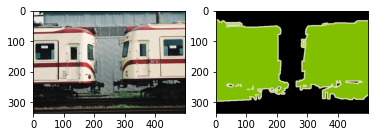

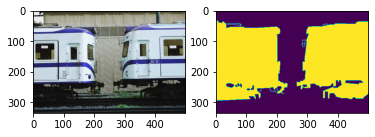

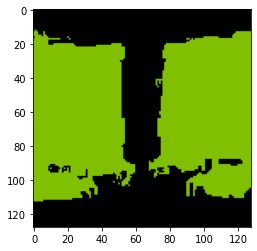

In [85]:
# Test dataset:
if DATASET == "pascal":
    dst  = pascalVOCLoader(root ='/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/',split = "train"
                           ,img_size=(INPUT_SIZE,INPUT_SIZE),is_transform=True
                           ,augmentations= Compose([RandomRotate(10)
                                                    , RandomHorizontallyFlip(p=0.5)
                                                   ,AdjustGamma(gamma = 2.2)
                                                   ]))
#TODO: if DATASET == ...
    
fname = "2007_000042"
lbl_path = pjoin('/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/', "SegmentationClass", fname+".png")
img_path = pjoin('/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/', "JPEGImages", fname+".jpg")


#read

x = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
y = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
x = cv2.cvtColor(np.array(x), cv2.COLOR_BGR2RGB)
y = cv2.cvtColor(np.array(y), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)
print("image shape just after reading: ", (x).shape)

#pre-encode

encoded_label = dst.encode_segmap(y)
print("pre-encoded label before saving as png: ", np.unique(encoded_label))


#write

cv2.imwrite(pjoin("encoded_for_test", fname+".png"), encoded_label)#, high=encoded_label.max(), low=encoded_label.min())
#m.imsave(pjoin("encoded_for_test", fname+".png"), lbl)



#read


read_label = cv2.imread(pjoin("encoded_for_test", fname+".png"), cv2.IMREAD_UNCHANGED)
read_image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)



print("label right after reading pre-encoded file: ",np.unique(read_label))
fig, ax = plt.subplots(1,2)
ax[0].imshow(read_image)
ax[1].imshow(read_label)

#transform

read_image, read_label = dst.transform(read_image, read_label)
print("label shape after transform: ", read_label.shape)

print("label after loading and transforms: ",np.unique(read_label))
decoded_label = dst.decode_segmap(read_label.numpy())
fig = plt.figure("decoded label")
plt.imshow(decoded_label)

In [93]:
# Test Dataloader

#import ptsemseg.augmentations as aug
%matplotlib inline
import matplotlib.pyplot as plt

if __name__ == '__main__':
    
    local_path = '/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/'
    bs = BATCH_SIZE
    if DATASET == "pascal":    
        dset = pascalVOCLoader(root=local_path, split = 'train_aug',img_size=(INPUT_SIZE,INPUT_SIZE)
                               , is_transform=True , aug_with_sbd=True
                               , augmentations=  Compose([RandomRotate(10), RandomHorizontallyFlip(p=0.5)
                                                          ,RandomVerticallyFlip(p=0.5),RandomSizedCrop(125)
                                                          ,AdjustGamma(gamma = 2.2),AdjustContrast(cf=0.4)]))

                                                      
        print(len(dset))
    #if DATASET == ...
    
    trainloader = dt.DataLoader(dset, batch_size=bs, shuffle=True)

    for i, data in enumerate(trainloader): # i = batch idx , data = (img , label) (as tensors - first dim is batch size)
        img, label = data
        #print('img tensor shape: ',img.shape)
        #print("img tensor unique", img.unique())
        img = img.numpy()#[:, ::-1, :, :]
        #print('img numpy shape: ',img.shape)
        img = np.transpose(img, [0,2,3,1])
        #print('img numpy transpose shape: ',img.shape)
        #print("image uniques:",np.unique(img))
        #print('lbl tensor shape',label.shape)
        print("label values:",label.unique())
    
        f, axarr = plt.subplots(bs, 2, figsize=(15, 15), dpi=80)
        
        for j in range(bs):
            print("batch item {} img shape: {} label shape: {}".format(bs,img[j].shape,label.numpy()[j].shape))
            axarr[j,0].imshow(img[j])
            axarr[j,1].imshow(dst.decode_segmap(np.squeeze(label[j].numpy())))
        plt.show()
    
    plt.close()


pre-encode test: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s]


0


ValueError: num_samples should be a positive integer value, but got num_samples=0

## Define DataLoaders

In [98]:
# Define Train/Val Loaders
    
def data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split = "train"
                , augmentations = None, shuffle = True
               ,aug_with_sbd=False):
    
    
    if dataset_name == "pascal":
        data_path = "/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/"
        dataset = pascalVOCLoader(root=data_path, split=split
                                  , is_transform=True, augmentations=augmentations
                                  , aug_with_sbd=aug_with_sbd)
        print(split+" dataset size: {} images\n".format(len(dataset)))
    #if dataset_name = ...
    
    loader = dt.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    
    return loader

# TRAIN

In [ ]:
### TRAIN

# libraries
import os
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(17)


def main():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    nEpochs = NUM_EPOCHS 
    terminal_show_freq = 60 

    DATASET_NAME = DATASET
    root = "."
    
    # define augmentations, or assign "None"  
    augs = Compose([RandomSizedCrop(124), RandomRotate(10),RandomHorizontallyFlip(p=0.5),RandomVerticallyFlip(p=0.5), AdjustGamma(gamma = 2.2),AdjustContrast(cf=0.4)])

    train_loader = data_loader(dataset_name = DATASET, split = "train", augmentations = augs, aug_with_sbd=False)
    val_loader = data_loader(dataset_name = DATASET, split = "val" , augmentations = None, aug_with_sbd=False)
    
    
    n_classes = OUTPUT_CLASSES
    
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
        
    # whatever you are timing goes here
    
    if MODEL == "segnet":
        model = SegNet(in_channels=IN_CHANNELS, n_classes=OUTPUT_CLASSES)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    #scheduler = ReduceLROnPlateau(optimizer, 'min', verbose = True)
    scheduler = None
    
    #pretrain the model with VGG16 ImageNet params
    if PRETRAINED: 
        vgg16 = models.vgg16(pretrained=PRETRAINED)
        vgg16 = vgg16.to(device)
        model.init_vgg16_params(vgg16)
                
    model = model.to(device)
    print("Model transferred to GPU.....")

    
    if LOSS_TYPE == "BCE":
        criterion = WeightedCrossEntropyLoss(classes = OUTPUT_CLASSES, do_weight = False)
    elif LOSS_TYPE == "WBCE": 
        criterion = WeightedCrossEntropyLoss(classes = OUTPUT_CLASSES, do_weight = True)
    elif LOSS_TYPE == "Dice":
        criterion = DiceLoss(classes = OUTPUT_CLASSES)
    else:
        print("Loss type not determined...using WBCE by default:")
        criterion = WeightedCrossEntropyLoss(classes = OUTPUT_CLASSES, do_weight = True)

        
    trainer = Trainer(root=root, nEpochs=nEpochs, terminal_show_freq=terminal_show_freq,
                      dataset_name = DATASET_NAME, classes = OUTPUT_CLASSES, model=model,
                      criterion=criterion, optimizer=optimizer, train_data_loader=train_loader,
                      valid_data_loader=val_loader, lr_scheduler=scheduler, device = device)
    print("STARTING TRAINING...")
    trainer.training()
    
    end.record()
    
    print("FINISHING TRAINING...")
    
    # Waits for everything to finish running
    torch.cuda.synchronize()
    print("time elapsed at training:{}: ".format(start.elapsed_time(end)))  # milliseconds

    
if __name__ == '__main__':
    main()



val dataset size: 1449 images

train dataset size: 1464 images

Model transferred to GPU.....
STARTING TRAINING...

Summary train Epoch  1:  Loss:3.0430 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch  2:  Loss:3.0311 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch  3:  Loss:3.0187 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat


Summary train Epoch 21:  Loss:2.9781 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 22:  Loss:2.9790 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 23:  Loss:2.9773 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	


Summary train Epoch 41:  Loss:2.9661 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 42:  Loss:2.9666 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 43:  Loss:2.9664 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	


Summary train Epoch 61:  Loss:2.9564 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 62:  Loss:2.9569 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 63:  Loss:2.9593 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	


Summary train Epoch 81:  Loss:2.9355 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 82:  Loss:2.9319 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 83:  Loss:2.9314 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	


Summary train Epoch 101:  Loss:2.8996 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 102:  Loss:2.8989 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 103:  Loss:2.8975 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 121:  Loss:2.8710 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 122:  Loss:2.8616 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 123:  Loss:2.8627 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 141:  Loss:2.8294 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 142:  Loss:2.8316 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 143:  Loss:2.8324 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 161:  Loss:2.8081 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 162:  Loss:2.7981 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 163:  Loss:2.7937 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 181:  Loss:2.7878 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 182:  Loss:2.7922 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 183:  Loss:2.7913 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 201:  Loss:2.7587 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 202:  Loss:2.7512 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 203:  Loss:2.7647 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 221:  Loss:2.7627 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 222:  Loss:2.7540 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 223:  Loss:2.7614 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 241:  Loss:2.7544 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 242:  Loss:2.7551 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 243:  Loss:2.7276 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 261:  Loss:2.7325 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 262:  Loss:2.7329 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 263:  Loss:2.7302 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 281:  Loss:2.7092 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 282:  Loss:2.6915 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 283:  Loss:2.6638 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 301:  Loss:2.6810 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 302:  Loss:2.6582 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 303:  Loss:2.6557 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 321:  Loss:2.6475 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 322:  Loss:2.6462 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 323:  Loss:2.6366 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 341:  Loss:2.6374 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 342:  Loss:2.6457 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 343:  Loss:2.6309 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 361:  Loss:2.6208 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 362:  Loss:2.5950 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 363:  Loss:2.6137 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 381:  Loss:2.6035 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 382:  Loss:2.6202 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 383:  Loss:2.6086 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 401:  Loss:2.5854 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 402:  Loss:2.5679 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 403:  Loss:2.5907 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 421:  Loss:2.5913 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 422:  Loss:2.5880 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 423:  Loss:2.5846 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 441:  Loss:2.5782 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 442:  Loss:2.5667 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 443:  Loss:2.6068 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 461:  Loss:2.5640 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 462:  Loss:2.5668 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 463:  Loss:2.5465 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 481:  Loss:2.5646 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 482:  Loss:2.5477 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 483:  Loss:2.5812 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 501:  Loss:2.5503 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 502:  Loss:2.5502 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 503:  Loss:2.5737 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 521:  Loss:2.5237 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 522:  Loss:2.5341 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 523:  Loss:2.5233 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 541:  Loss:2.5254 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 542:  Loss:2.5447 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 543:  Loss:2.5318 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 561:  Loss:2.5167 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 562:  Loss:2.5307 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 563:  Loss:2.5321 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 581:  Loss:2.5567 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 582:  Loss:2.5371 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 583:  Loss:2.5580 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 601:  Loss:2.5262 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 602:  Loss:2.5242 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 603:  Loss:2.5307 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 621:  Loss:2.4967 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 622:  Loss:2.5008 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 623:  Loss:2.5254 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 641:  Loss:2.4893 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 642:  Loss:2.4835 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 643:  Loss:2.4983 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 661:  Loss:2.5022 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 662:  Loss:2.4973 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 663:  Loss:2.5055 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 681:  Loss:2.5241 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 682:  Loss:2.5036 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 683:  Loss:2.5187 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 701:  Loss:2.5028 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 702:  Loss:2.4808 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 703:  Loss:2.5167 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 721:  Loss:2.4845 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 722:  Loss:2.4688 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 723:  Loss:2.4727 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 741:  Loss:2.4879 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 742:  Loss:2.4696 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 743:  Loss:2.4486 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 761:  Loss:2.4605 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 762:  Loss:2.4701 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 763:  Loss:2.4809 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 781:  Loss:2.4628 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 782:  Loss:2.4720 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 783:  Loss:2.4535 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 801:  Loss:2.4786 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 802:  Loss:2.4852 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 803:  Loss:2.4726 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 821:  Loss:2.4784 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 822:  Loss:2.4747 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 823:  Loss:2.4827 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 841:  Loss:2.4601 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 842:  Loss:2.4486 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 843:  Loss:2.4640 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 861:  Loss:2.4633 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 862:  Loss:2.4537 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 863:  Loss:2.4844 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 881:  Loss:2.4631 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 882:  Loss:2.4559 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 883:  Loss:2.4650 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 901:  Loss:2.4399 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 902:  Loss:2.4450 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 903:  Loss:2.4455 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 921:  Loss:2.5751 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 922:  Loss:2.5603 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 923:  Loss:2.4883 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 941:  Loss:2.4980 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 942:  Loss:2.4821 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 943:  Loss:2.4601 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 961:  Loss:2.4389 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 962:  Loss:2.4445 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 963:  Loss:2.4312 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 981:  Loss:2.4354 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 982:  Loss:2.4313 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 983:  Loss:2.4061 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.00


Summary train Epoch 1001:  Loss:2.4283 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1002:  Loss:2.4391 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1003:  Loss:2.4331 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1021:  Loss:2.4828 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1022:  Loss:2.4529 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1023:  Loss:2.4353 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1041:  Loss:2.4484 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1042:  Loss:2.4280 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1043:  Loss:2.4230 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1061:  Loss:2.4067 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1062:  Loss:2.4426 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1063:  Loss:2.4296 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1081:  Loss:2.4173 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1082:  Loss:2.4289 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1083:  Loss:2.4263 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1101:  Loss:2.4738 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1102:  Loss:2.4499 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1103:  Loss:2.4392 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1121:  Loss:2.4242 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1122:  Loss:2.4082 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1123:  Loss:2.4167 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1141:  Loss:2.4133 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1142:  Loss:2.4281 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1143:  Loss:2.4167 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1161:  Loss:2.4022 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1162:  Loss:2.4009 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1163:  Loss:2.3886 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1181:  Loss:2.4042 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1182:  Loss:2.3931 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1183:  Loss:2.3925 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1201:  Loss:2.4018 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1202:  Loss:2.3909 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1203:  Loss:2.4067 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1221:  Loss:2.4020 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1222:  Loss:2.3928 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1223:  Loss:2.4285 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1241:  Loss:2.4213 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1242:  Loss:2.4025 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1243:  Loss:2.3993 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1261:  Loss:2.4086 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1262:  Loss:2.4052 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1263:  Loss:2.4091 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1281:  Loss:2.4244 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1282:  Loss:2.4018 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1283:  Loss:2.4051 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1301:  Loss:2.3985 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1302:  Loss:2.4149 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1303:  Loss:2.4055 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1321:  Loss:2.4204 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1322:  Loss:2.4626 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1323:  Loss:2.4407 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1341:  Loss:2.4183 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1342:  Loss:2.3992 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1343:  Loss:2.3959 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1361:  Loss:2.5345 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1362:  Loss:2.4598 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1363:  Loss:2.4418 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1381:  Loss:2.3894 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1382:  Loss:2.3943 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1383:  Loss:2.3874 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1401:  Loss:2.3850 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1402:  Loss:2.3763 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1403:  Loss:2.4034 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1421:  Loss:2.3865 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1422:  Loss:2.3882 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1423:  Loss:2.3818 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1441:  Loss:2.3835 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1442:  Loss:2.3710 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1443:  Loss:2.3712 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1461:  Loss:2.3871 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1462:  Loss:2.3661 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1463:  Loss:2.3933 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1481:  Loss:2.3919 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1482:  Loss:2.3725 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1483:  Loss:2.3679 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1501:  Loss:2.3718 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1502:  Loss:2.3733 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1503:  Loss:2.3982 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1521:  Loss:2.3649 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1522:  Loss:2.3709 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1523:  Loss:2.3640 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0


Summary train Epoch 1541:  Loss:2.3624 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1542:  Loss:2.3703 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0.0000	dog : 0.0000	horse : 0.0000	motorbike : 0.0000	person : 0.0000	potted plant : 0.0000	sheep : 0.0000	sofa : 0.0000	train : 0.0000	tv/monitor : 0.0000

Summary train Epoch 1543:  Loss:2.3814 	 DSC:0.0000  	bg : 0.0000	aeroplane : 0.0000	bicycle : 0.0000	bird : 0.0000	boat : 0.0000	bottle : 0.0000	bus : 0.0000	car : 0.0000	cat : 0.0000	chair : 0.0000	cow : 0.0000	dining table : 0

# LOAD N' TEST 

In [60]:
# Reading and evaluating the trained model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_trained = "./trained/segnet/models/"
model_name = MODEL+"_"+DATASET+"_ep2000_lr0.0001_bs4_pretrained_WBCE"

if MODEL == "segnet":
    model = SegNet(in_channels=IN_CHANNELS, n_classes=OUTPUT_CLASSES)
#TODO: if MODEL == ...
    
model = model.to(device)

if str(device) == 'cuda':
    print('loading model on GPU')
    model.load_state_dict(torch.load(path_trained + model_name + '.pth'))
else:
    print('loading model on CPU')
    model.load_state_dict(torch.load(path_trained + model_name  +'.pth', map_location='cpu'))    
model.eval()

print('Trained model is loaded and ready for evaluation.')

loading model on GPU
Trained model is loaded and ready for evaluation.


## Visualize Results

qualitative results on test data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: index 2 is out of bounds for dimension 0 with size 2

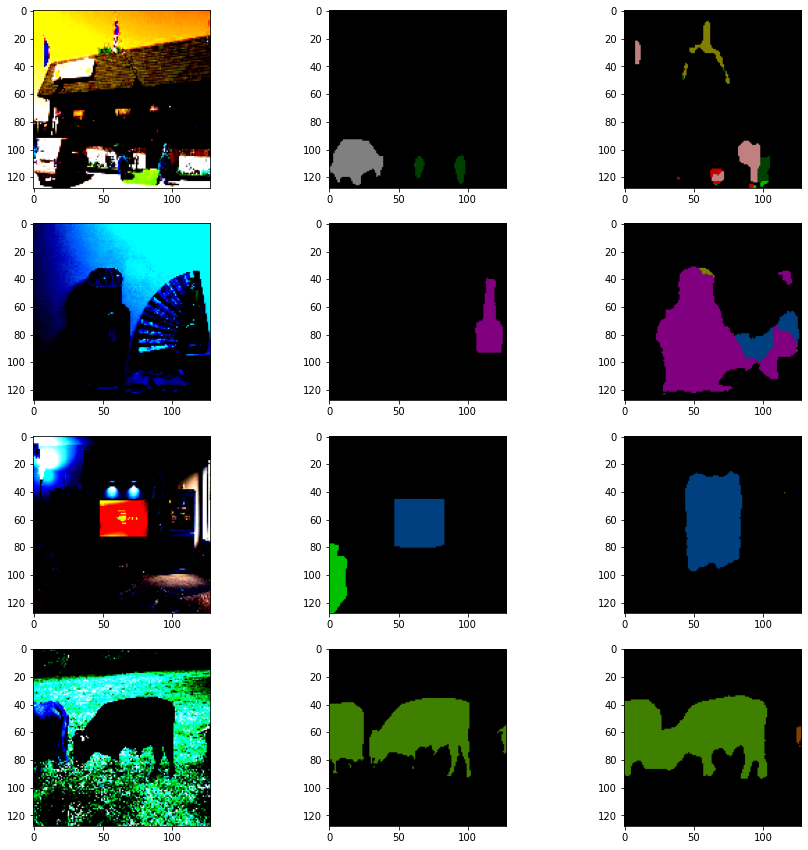

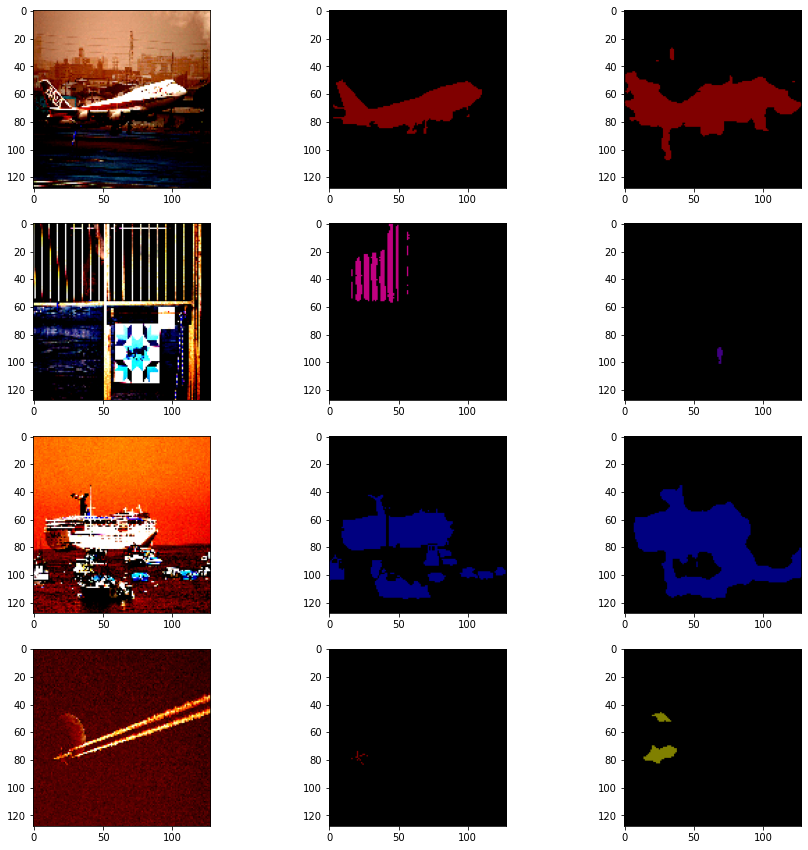

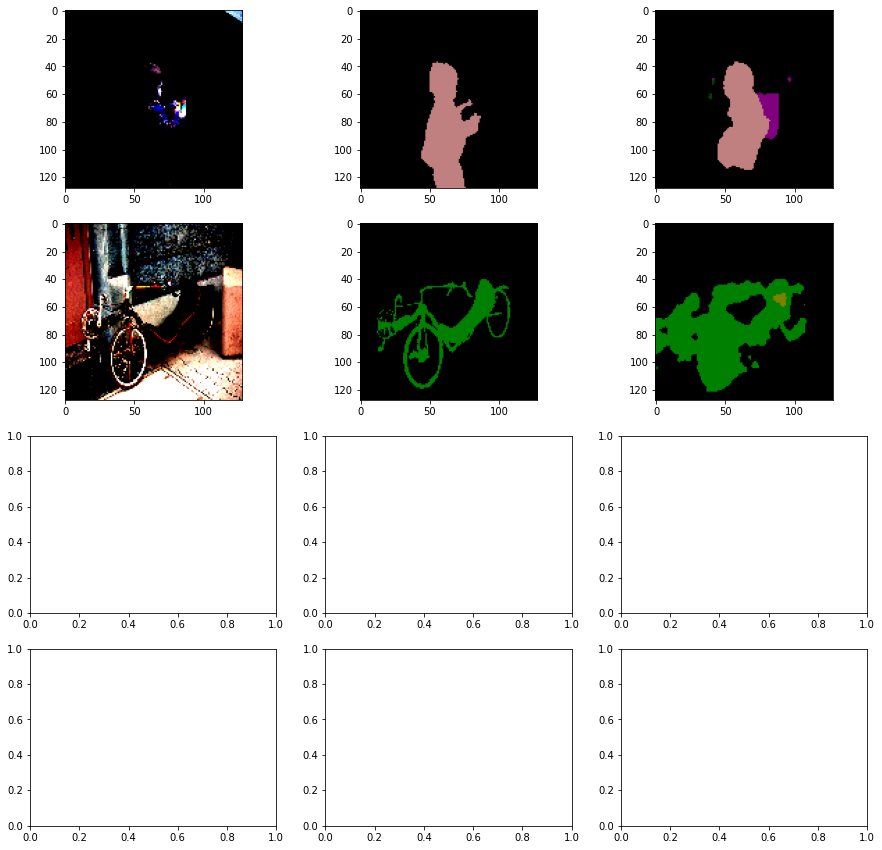

In [61]:
local_path = '/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/'
dst = pascalVOCLoader(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), is_transform=True, augmentations=None)
test_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split="test",shuffle = False)
#train_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split="train")
print("qualitative results on test data:")

for batch_idx, input_tuple in enumerate(test_loader):
    #some transorms to show image in cpu:
    img = input_tuple[0]
    lbl = input_tuple[1]
    img = img.numpy()[:, ::-1, :, :]
    img = np.transpose(img, [0,2,3,1])

    input_tensor, target = prepare_input(input_tuple=input_tuple, cuda=True if torch.cuda.is_available() else False)
    input_tensor.requires_grad = False
    
    # ********************************  Visualize Results ************************************
    
    with torch.no_grad():
        
        output = model(input_tensor)
    
        # Create 2D output array with different indices for each class (Collapse 1-hot tensor to 2D array)
        
        predicted_labels = np.zeros((BATCH_SIZE, output.shape[-2], output.shape[-1]))

        fig, ax = plt.subplots(BATCH_SIZE,3,figsize=(15,15))
        
        for item in range(BATCH_SIZE):

            lbl_array = output[item].detach().cpu().numpy()
            predicted_labels[item] = np.argmax(lbl_array, axis = 0)
                        
            ax[item,0].imshow(img[item]) #show the 1st item in batch
            ax[item,1].imshow(dst.decode_segmap(target[item].detach().cpu().numpy()))
            ax[item,2].imshow(dst.decode_segmap(predicted_labels[item]))
'''       
print("results on training data:")

for batch_idx, input_tuple in enumerate(train_loader,start=-20):
    #some transorms to show image in cpu:
    img = input_tuple[0]
    lbl = input_tuple[1]
    img = img.numpy()
    img = np.transpose(img, [0,2,3,1])

    input_tensor, target = prepare_input(input_tuple=input_tuple, cuda=True if torch.cuda.is_available() else False)
    input_tensor.requires_grad = False
    
    # ********************************  Visualize Results ************************************
    
    with torch.no_grad():
        
        output = model(input_tensor)
    
        # Create 2D output array with different indices for each class (Collapse 1-hot tensor to 2D array)
        
        predicted_labels = np.zeros((BATCH_SIZE, output.shape[-2], output.shape[-1]))

        fig, ax = plt.subplots(BATCH_SIZE,3,figsize=(15,15))
        
        for item in range(BATCH_SIZE):

            lbl_array = output[item].detach().cpu().numpy()
            predicted_labels[item] = np.argmax(lbl_array, axis = 0)
                        
            ax[item,0].imshow(img[item]) #show the 1st item in batch
            ax[item,1].imshow(dst.decode_segmap(target[item].detach().cpu().numpy()))
            ax[item,2].imshow(dst.decode_segmap(predicted_labels[item]))

'''

In [62]:
# mIOU

def calculate_performance(ground_truth, predicted_labels):
    # the inputs of this function are Boolean values for specific classes
    # this function calculates TP, TF, FP, FN, and then performance measures
    nPixels = ground_truth.size

    TP = np.sum(np.bitwise_and(ground_truth,predicted_labels))
    TN = nPixels - np.sum(np.bitwise_or(ground_truth,predicted_labels))
    
    comparison_mat = ground_truth.astype(int) - predicted_labels.astype(int)
    
    
    FN = np.sum( comparison_mat == 1 )
    FP = np.sum( comparison_mat == -1 )
    
    assert (TP + TN + FN + FP == nPixels)
    
    if (TP + FP + FN)!=0: 
        iou_val = (TP) / (TP + FP + FN)
    else: 
        iou_val = 0
    
    if (2*TP + FP + FN)!=0:
        dice_coeff = 2*TP / (2*TP + FP + FN)
    else:
        dice_coeff = 0
        
    if (2-dice_coeff)!=0:    
        jaccard_idx = dice_coeff / (2-dice_coeff) # jaccard similarity coefficient
    else:
        jaccard_idx = 0
        
    if (TP + FN)!=0:
        sensitivity = TP / (TP + FN) # recall rate, percentage match
    else:
        sensitivity = 0
        
    if (TP + FP)!=0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    if (2*TP + FP + FN)!=0:    
        vol_distance = np.abs(FN-FP)/(2*TP + FP + FN) #volumetric distance
    else:
        vol_distance = 0
#     #directed_hausdorff
#     from scipy.spatial.distance import directed_hausdorff
    
#     hd_sg = max(directed_hausdorff(ground_truth, predicted_labels))
#     hd_gs = max(directed_hausdorff(predicted_labels, ground_truth))
#     hd = max(hd_sg,hd_gs)
    
    return iou_val, dice_coeff, sensitivity, precision

def get_performance_measures(ground_truth, predicted_labels, names, print_on = True, nClasses = OUTPUT_CLASSES):

    # Initialize performance measures
    iou = np.zeros((1,nClasses))
    dce = np.zeros((1,nClasses))
    sen = np.zeros((1,nClasses))
    pre = np.zeros((1,nClasses))

    # Calculate measures for each class
    if print_on:
        print('\n--------------Performance-------------')
        print("\t IOU \t DICE \t SENS \t PRE")
        
    for iClass in range(0,nClasses):
        # Detect pixels that are segmented as iClass
        gt = ground_truth == iClass
        pred = predicted_labels == iClass

        [iou[0,iClass],dce[0,iClass],sen[0,iClass],pre[0,iClass]] = calculate_performance(gt,pred)
        
        if print_on:
            print(names[iClass] + ":\t {:.3} \t {:.3} \t {:.3} \t {:.3}".format(iou[0,iClass],dce[0,iClass],sen[0,iClass],pre[0,iClass]))

    # Calculate the means    
    mIOU  = np.mean(iou)  
    mDICE = np.mean(dce)  
    mSENS = np.mean(sen)  
    mPRE  = np.mean(pre)  
    
    if print_on:
        print('\n----------------Summary---------------')
        print("Means:\t {:.3} \t {:.3} \t {:.3} \t {:.3}\n".format(mIOU,mDICE,mSENS,mPRE))

        
    return iou, dce, sen, pre

## Evaluate Performance

In [63]:
local_path = '/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/'
dst_test = pascalVOCLoader(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), split = "val", is_transform=True, augmentations=None)

test_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split="val")
#train_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split="train")

iou_list = [np.zeros((1,len(dict_class_names["pascal"])))]*len(dst_test)
dce_list = [np.zeros((1,len(dict_class_names["pascal"])))]*len(dst_test)
sen_list = [np.zeros((1,len(dict_class_names["pascal"])))]*len(dst_test)
pre_list = [np.zeros((1,len(dict_class_names["pascal"])))]*len(dst_test)
gt_labels = [None]*len(dst_test) 

print("quantitative results on test data:")

for batch_idx, input_tuple in enumerate(test_loader):

    input_tensor, target = prepare_input(input_tuple=input_tuple, cuda=True if torch.cuda.is_available() else False)
    input_tensor.requires_grad = False
    
    # ********************************  Get Results ************************************
    
    with torch.no_grad():
        
        output = model(input_tensor)

        # Collapse 1-hot tensor to 2D array
        
        predicted_labels = np.zeros((BATCH_SIZE, output.shape[-2], output.shape[-1]))
        
        for item in range(BATCH_SIZE):
            try:
                out_array = output[item].detach().cpu().numpy()
            
            #ignore index errors if len(dataset)/batchsize is not an integer
            except IndexError: 
                break
            predicted_labels[item] = np.argmax(out_array, axis = 0)             
            gt_labels[item] = target[item].detach().cpu().numpy()
            
            [iou_list[(batch_idx+1)*(item+1)-1], dce_list[(batch_idx+1)*(item+1)-1], sen_list[(batch_idx+1)*(item+1)-1], pre_list[(batch_idx+1)*(item+1)-1]] = get_performance_measures(gt_labels[item]
                                                                , predicted_labels[item]
                                                                , names = dict_class_names["pascal"]
                                                                , print_on = False)
            
            
#print(iou_list)            
mIOU = np.mean(np.stack(iou_list,0),0)
print("mIOU:",mIOU)
mDCE = np.mean(np.stack(dce_list,0),0)
print("Dice:",mDCE)
mSEN = np.mean(np.stack(sen_list,0),0)
print("Sensitivity:",mSEN)

print("number of samples: ",len(dst_test))                

quantitative results on test data:
mIOU: [[0.49117745 0.01859118 0.00527832 0.01189454 0.00800469 0.00590237
  0.01323889 0.01491409 0.02245108 0.0037667  0.00758572 0.00650669
  0.01674505 0.00899731 0.0128938  0.06896812 0.00331374 0.00905465
  0.00832831 0.0182733  0.01032552]]
Dice: [[0.53458825 0.02237419 0.00846046 0.0156367  0.01035596 0.0074392
  0.0155811  0.01781034 0.02691182 0.00600847 0.00925486 0.00808989
  0.02045755 0.01129171 0.01638899 0.0865209  0.00457133 0.01118413
  0.01070469 0.02125823 0.01284666]]
Sensitivity: [[0.53603346 0.02837485 0.02002421 0.01683424 0.01472642 0.00794299
  0.01583541 0.01838243 0.03005642 0.00813874 0.00980623 0.00725403
  0.02146894 0.01233817 0.01838898 0.09378324 0.00575164 0.01282981
  0.00956519 0.02111074 0.01518149]]
number of samples:  1449


In [ ]:
# TODOs: change m.imread to cv2 imread
# saved model resume train
# per-class score: add to logging  read https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
# mIOU
# Instance Segmentation
# EgoHands Polygon to Mask